### MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### IMPORT

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [ ]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
pass

In [ ]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### CONSTANTS

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/SNAMA"

DATA_PATH = os.path.join(PROJECT_DIR, "data")
CHECKPOINTS_PATH = os.path.join(PROJECT_DIR, "checkpoints")
MODELS_PATH = os.path.join(PROJECT_DIR, "models")

DATASET_NAME = "amazon_reviews.csv"
DATASET_PATH = os.path.join(DATA_PATH, DATASET_NAME)

PREPROCESSED_DATASET_NAME = "amazon_reviews_preprocessed.pckl"
PREPROCESSED_LABELS_NAME = "amazon_reviews_preprocessed_labels.pckl"

In [ ]:
__LOGICAL_CORES__ = 0x4

### IO

In [ ]:
def dump_object(data, file, directory):
    with open(os.path.join(directory, file), 'wb') as file:
        pickle.dump(data, file)


def load_object(file, directory):
    with open(os.path.join(directory, file), 'rb') as file:
        data = pickle.load(file)
        return data


def exists_object(file, directory):
    return os.path.isfile(os.path.join(directory, file))


def dump_model(data, file, directory=MODELS_PATH):
    dump_object(data, file, directory)


def load_model(file, directory=MODELS_PATH):
    return load_object(file, directory)


def exists_model(file, directory=MODELS_PATH):
    return exists_object(file, directory)


def dump_checkpoint(data, file, directory=CHECKPOINTS_PATH):
    dump_object(data, file, directory)


def load_checkpoint(file, directory=CHECKPOINTS_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=CHECKPOINTS_PATH):
    return exists_object(file, directory)


def load_dataset_from_csv(file, directory=DATA_PATH):
    dataframe_ = pd.read_csv(os.path.join(directory, file))
    return dataframe_.Text.values, dataframe_.Score.values


def dump_dataset(data, file, directory=DATA_PATH):
    dump_object(data, file, directory)


def load_dataset(file, directory=DATA_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=DATA_PATH):
    return exists_object(file, directory)

### PREPROCESSING FUNCTIONS

In [ ]:
def get_wordnet_pos(tag):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag[0x0], wordnet.NOUN)

In [ ]:
def get_corpus(dataset):
    corpus = set()

    for text in dataset:
        tokens = nltk.word_tokenize(text)
        corpus = corpus.union(tokens)

    return corpus

In [ ]:
def preprocess_dataset(dataset):
    word_net_lemmatizer = WordNetLemmatizer()

    en_stopwords = set(stopwords.words("english"))

    for i in range(dataset.shape[0x0]):
        dataset[i] = re.sub(r'\W+', " ", re.sub(r"<.*?>", " ", dataset[i]))\
                        .strip()\
                        .lower()

        tagged_words = pos_tag(nltk.word_tokenize(dataset[i]))

        processed_words = []

        for j, (word, tag) in enumerate(tagged_words):

            if len(word) > 0x1 and word not in en_stopwords and word.isalpha():
                processed_words.append(word_net_lemmatizer.lemmatize(word, get_wordnet_pos(tag)))

        dataset[i] = " ".join(processed_words)

### DATASET PREPROCESSING

In [ ]:
dataset, labels = load_dataset_from_csv(DATASET_NAME)

In [ ]:
size = dataset.shape[0x0]

In [ ]:
executor = ThreadPoolExecutor(max_workers=__LOGICAL_CORES__)

In [ ]:
jobs = []
chunk_size = np.ceil(size / __LOGICAL_CORES__).astype(np.int64)
   
for chunk in range(__LOGICAL_CORES__):
    jobs.append(executor.submit(preprocess_dataset,
                                dataset[chunk * chunk_size : min((chunk + 0x1) * chunk_size, size)]))
    
for job in jobs:
    job.result()

In [ ]:
executor.shutdown()

In [ ]:
raw_dataset, _ = load_dataset_from_csv(DATASET_NAME)

In [ ]:
raw_dataset[: 0xa]

array(["i didn't buy these to eat... i bought them as a centerpiece for a circus themed baby shower.  I filled a large  vase with the gumballs and used on buffet table.  I did try one out of curiousity and they were extremely hard and lost flavor within seconds.  SO... highly recommend for decor purposes.  don't recommend for flavor purposes unless you want a jaw workout.",
       'No customer service or follow up after you make a complaint. Go to another store, you pay alittle bit more but atleast you will get some service.',
       "I love this stuff.  The normal flavor is really good, but I like to add a couple tablespoons of Hershey's Dark chocolate cocoa powerder.  If you love dark chocolate give this a try.  Delicious!",
       'This chocolate pudding mix is great. My niece enjoyed it very much. It has a great taste and nice consistency. there is one con: You may lose control of your life when making this at 4 AM',
       'JELLO Sugar Free, Fat Free Chocolate Fudge is such an ind

In [ ]:
dataset[: 0xa]

array(['buy eat buy centerpiece circus theme baby shower fill large vase gumballs use buffet table try one curiousity extremely hard lose flavor within second highly recommend decor purpose recommend flavor purpose unless want jaw workout',
       'customer service follow make complaint go another store pay alittle bit atleast get service',
       'love stuff normal flavor really good like add couple tablespoon hershey dark chocolate cocoa powerder love dark chocolate give try delicious',
       'chocolate pudding mix great niece enjoy much great taste nice consistency one con may lose control life make',
       'jello sugar free fat free chocolate fudge indulgence never guess free version real thing taste satisfying chocolholic willing forgive less desirable aspartame sweetener little nutrition make cup filter water one hard boil egg protein lot nutrient yolk hardly notice make without milk automatic classic dessert menu',
       'excellent always one say jello p try make choclate mil

In [ ]:
__EXPORT_DATASET__ = False
if __EXPORT_DATASET__:
    dump_dataset(dataset, PREPROCESSED_DATASET_NAME)

In [ ]:
corpus = get_corpus(dataset)

In [ ]:
len(corpus)

59692

In [ ]:
len_df = pd.DataFrame({"lens": np.asarray([len(dataset[i]) for i in range(dataset.shape[0x0])])}) 

In [ ]:
len_df.describe()

,lens
count,191486.000000
mean,268.612750
std,280.474627
min,5.000000
25%,109.000000
50%,187.000000
75%,326.000000
max,14004.000000


In [ ]:
np.sum(len_df.lens > 326)

47734

In [ ]:
np.sum(len_df.lens > 500)

22477

In [ ]:
np.sum(len_df.lens > 750)

9169

In [ ]:
np.sum(len_df.lens > 1000)

4348

In [ ]:
np.sum(len_df.lens > 1250)

2290

In [ ]:
np.sum(len_df.lens > 1500)

1403

In [ ]:
np.sum(len_df.lens > 1750)

917

In [ ]:
np.sum(len_df.lens > 2000)

652

### LABELS PREPROCESSING

In [ ]:
labels_df = pd.DataFrame({"labels": labels})

In [ ]:
data = labels_df.labels.value_counts()

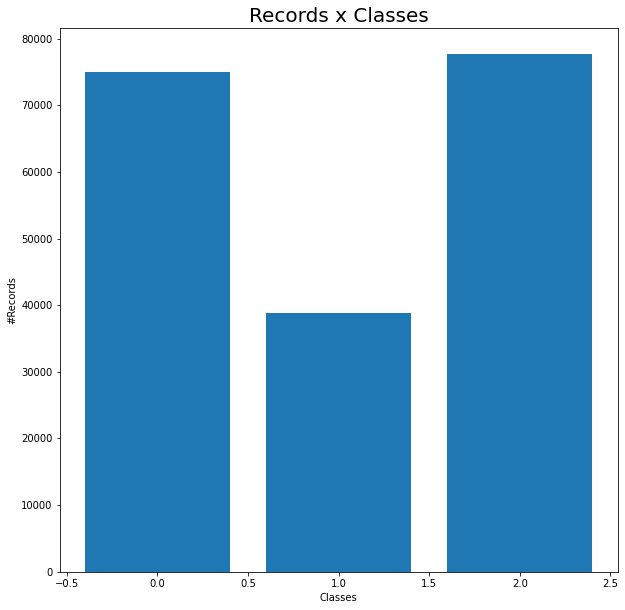

In [ ]:
plt.figure(figsize=(0xa, 0xa))
plt.bar(x=data.index, height=data)
plt.ylabel("#Records")
plt.xlabel("Classes")
plt.title("Records x Classes", size=0x14)
plt.show()

In [ ]:
data

2    77672
0    74985
1    38829
Name: labels, dtype: int64

In [ ]:
__EXPORT_LABELS__ = True
if __EXPORT_LABELS__:
    dump_dataset(labels, PREPROCESSED_LABELS_NAME)